# Models Comparison for TinyML

In [24]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
from pandas import read_csv
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import m2cgen as m2c
from micromlgen import port

import warnings
import seaborn as sbs
import sys

warnings.filterwarnings('ignore')

In [25]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)

In [26]:
with open('data/X2.pkl', 'rb') as f:
    X = pickle.load(f)

with open('data/y2.pkl', 'rb') as f:
    y = pickle.load(f)

In [27]:
X.shape

(750, 32)

In [28]:
labels = 5
samples = 150
X = X[:labels*samples]
y = y[:labels*samples]


In [29]:
classes = np.unique(y).tolist()
for i in range(len(classes)):
    y = np.where(y==classes[i], i, y)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

In [31]:
scaler = RobustScaler()

In [32]:
X_test.shape

(150, 32)

## Model Spotting

In [33]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'f1_macro'


In [34]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.05, random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=seed, n_estimators = 50)))


In [35]:
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_train = scaler.fit_transform(X_cross_train)
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        X_cross_test = scaler.transform(X_cross_test)
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,31 0,05
LR - 0,43 0,06
CART - 0,42 0,08
SVC - 0,56 0,05
RF - 0,54 0,05


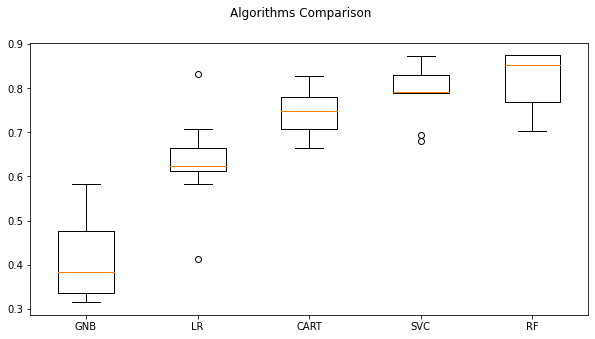

In [18]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Valutazione dei migliori algoritmi su test

# Valutazione modelli sul Test Set

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    print(classification_report(y_test, pred_test))
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       0.43      0.10      0.16        30
           1       0.49      0.87      0.63        30

    accuracy                           0.48        60
   macro avg       0.46      0.48      0.39        60
weighted avg       0.46      0.48      0.39        60

-------------------------------------------------------------
Model LR: 
              precision    recall  f1-score   support

           0       0.66      0.63      0.64        30
           1       0.65      0.67      0.66        30

    accuracy                           0.65        60
   macro avg       0.65      0.65      0.65        60
weighted avg       0.65      0.65      0.65        60

-------------------------------------------------------------
Model CART: 
              precision    recall  f1-score   support

           0       0.84      0.70      0.76        30
           1       0.74      0.87      0.80        30

    accuracy          

# Valutazione Inferance Rate medio (|X_test| = 40)

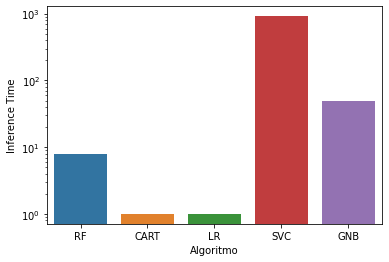

In [79]:
csv = read_csv("InfTimeReport.csv")
g = sbs.barplot(x=csv['Algoritmo'], y=csv['InfTime'])
g.set_yscale("log")
plt.ylabel("Inference Time")
plt.show()

# Memoria occupata

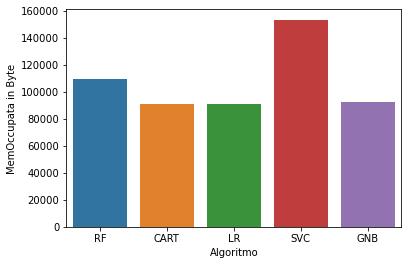

In [80]:
csv = read_csv("MemOccupationReport.csv")
sbs.barplot(x=csv['Algoritmo'], y=csv['MemOccupata2'])
plt.ylabel("MemOccupata in Byte")
plt.show()

# Export Models in C code

In [81]:
for name, model in models:
    prepath = 'exportedModels/' + str(labels) + "/"
    path = prepath + name + '.h'
    with open(path, 'w') as f:
        f.write(port(model, optimize=True))